In [2]:
import sparql_dataframe

import pandas
endpoint = "http://172.23.0.2:8890/sparql"
#pandas.set_option('display.max_rows', None)

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from rdflib import RDF, OWL, RDFS

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

prefixes = """

prefix dct:	<http://purl.org/dc/terms/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix samm: <https://owaspsamm.org/model/>
prefix enisa: <https://par-tec.it/onto/enisa/>
prefix ethreat: <https://par-tec.it/onto/enisa/threat/>
prefix pt: <https://par-tec.it/security/>
prefix dct: <http://purl.org/dc/terms/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix d3f: <http://d3fend.mitre.org/ontologies/d3fend.owl#> 

"""

CONSTRUCT_ER = """
CONSTRUCT {
    ?object ?rel ?subject 
}
WHERE {
?rel rdfs:domain ?object;
     rdfs:range ?subject
.
}
"""

# d3f

Overview: SAMM model is made of different classes:

- BusinessFunctions
- Practices
- Each practice has subpractices of different maturity levels, named PracticeLevels
- Each PracticeLevel has Actions divided in 2 Streams

The following graph describes the structure of the ontology



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.700973 to fit



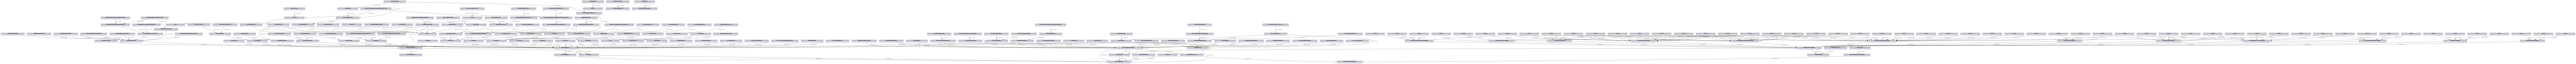

In [14]:
from rdflib import Graph
samm_g = Graph()
samm_g.parse("vocabularies/d3fend.ttl", format="turtle")

ret1 = samm_g.query("""
CONSTRUCT {
    ?object ?rel ?subject 
}
WHERE {
?rel rdfs:domain ?object;
     rdfs:range ?subject
.
FILTER (
regex(str(?subject), "http://d3fend.mitre.org", "i")
)
}
""")
ret2 = samm_g.query("""
CONSTRUCT {
    ?object rdfs:subClassOf ?subject 
}
WHERE {
[] rdfs:subClassOf ?object;
   a owl:NamedIndividual
.
?object rdfs:subClassOf ?subject
.
FILTER (
regex(str(?subject), "http://d3fend.mitre.org", "i")
)
}
""")

visualize(ret2.graph)


* there are 5 Business Functions mapped as samm:BusinessFunction
* each BusinessFunction has 3 samm:Practices; I don't know if this number is a constraint or is just for simplicity.


In [11]:

overview = """

Select ?f_l, ?p_l, ?ptype WHERE {

?f a samm:BusinessFunction;
  rdfs:label ?f_l

. 

?p _:b ?f;
  rdfs:label ?p_l;
  rdf:type ?ptype


}

"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,f_l,p_l,ptype
0,Governance,Strategy & Metrics,https://owaspsamm.org/model/Practice
1,Implementation,Secure Deployment,https://owaspsamm.org/model/Practice
2,Design,Security Architecture,https://owaspsamm.org/model/Practice
3,Governance,Education & Guidance,https://owaspsamm.org/model/Practice
4,Operations,Environment Management,https://owaspsamm.org/model/Practice
5,Verification,Architecture Assessment,https://owaspsamm.org/model/Practice
6,Design,Security Requirements,https://owaspsamm.org/model/Practice
7,Verification,Requirements-driven Testing,https://owaspsamm.org/model/Practice
8,Operations,Operational Management,https://owaspsamm.org/model/Practice
9,Implementation,Secure Build,https://owaspsamm.org/model/Practice


## Practices

Every Practice is declined in various maturity levels: 1, 2, 3. This number is arbitrary and is constrained for simplicity.

In [12]:
overview = """

Select * WHERE {

?p a samm:MaturityLevel ;
  rdfs:label ?q
. 

}

"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,p,q
0,https://owaspsamm.org/model/0a1dc80f84964f2fa7...,1
1,https://owaspsamm.org/model/47dd82af343e4695a0...,2
2,https://owaspsamm.org/model/7bbfe31d447e48759e...,3


Activities are labeled in base of 3 maturity levels and two streams A and B.

The streams are arbitrarily two for simplicity. Labels `A` and `B` do not imply any relation of priority.

In [13]:
overview = """

Select ?practice, ?level, ?description WHERE {


[] a samm:PracticeLevel;  # Return all PracticeLevel...
  dct:description ?description;

  samm:hasPractice [      #   with the associated practice 
    rdfs:label ?practice
  ];
  samm:hasMaturityLevel [ #   and maturity
      rdfs:label ?level
  ]


}
ORDER BY ?practice

"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,practice,level,description
0,Architecture Assessment,1,Review the architecture to ensure baseline mit...
1,Architecture Assessment,2,Review the complete provision of security mech...
2,Architecture Assessment,3,Review the architecture effectiveness and feed...
3,Defect Management,3,Defect tracking across multiple components is ...
4,Defect Management,1,All defects are tracked within each project.
5,Defect Management,2,Defect tracking used to influence the deployme...
6,Education & Guidance,1,Offer staff access to resources around the top...
7,Education & Guidance,3,Develop in-house training programs facilitated...
8,Education & Guidance,2,Educate all personnel in the software lifecycl...
9,Environment Management,3,Conformity with continuously improving process...


## Streams

As we saw before, each security practice is declined in different level of maturity


In [14]:
overview = """

Select ?stream,  ?letter, ?order, ?description, ?practice WHERE {

[] a samm:Stream;  # Return all Streams...
  rdfs:label ?stream;
  dct:description ?description;

  samm:hasPractice [      #   with the associated practice 
    rdfs:label ?practice
  ];
  samm:hasLetter ?letter ;
  samm:hasOrder ?order


}
ORDER BY ASC (?practice +  ?letter)

"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,stream,letter,order,description,practice
0,Organization and Culture,B,2,Organization and culture focuses on promoting ...,Education & Guidance
1,Scalable Baseline,A,1,Scalable baseline focuses on the use of applic...,Security Testing
2,Application Risk Profile,A,1,An application risk profile helps to identify ...,Threat Assessment
3,Patching and Updating,B,2,The activities in this stream focus on the org...,Environment Management
4,Architecture Design,A,1,The design of a software architecture can sign...,Security Architecture
5,Misuse/Abuse Testing,B,2,"Misuse/Abuse Testing leverages fuzzing, misuse...",Requirements-driven Testing
6,Compliance Management,B,2,This stream focuses on identifying and providi...,Policy & Compliance
7,Measure and Improve,B,2,"This stream aims to drive the validity, releva...",Strategy & Metrics
8,Software Dependencies,B,2,External libraries are a significant part of m...,Secure Build
9,Incident Response,B,2,Incident Response starts the moment you acknow...,Incident Management


## Activities

and into two possible streams, resulting in a table of 3 * 2 possible activities for every Practice.

```
| Activity | Maturity | Stream |
| ...      | 1-3      | A-B    |
```

In [39]:
overview = """

Select ?activity,
?description, ?letter, ?level, 
?url WHERE {

?id a samm:Activity;  # Return all Activities...
  dct:description ?description;
  rdfs:seeAlso ?url ;
  skos:altLabel ?activity 
  ; samm:hasStream [      #   with the associated practice 
    samm:hasLetter ?letter
  ];
  samm:hasMaturityLevel [
      rdfs:label ?level
  ]



}

"""
df =sparql_dataframe.get(endpoint, prefixes+ overview)

In [44]:
print(df.description.values[0])

Security is the responsibility of all employees, not just the Information Security team. Deploy communication and knowledge sharing platforms to help developers build communities around different technologies, tools, and programming languages. In these communities employees share information, discuss challenges with other developers, and search the knowledge base for answers to previously discussed issues.

Form communities around roles and responsibilities and enable developers and engineers from different teams and business units to communicate freely and benefit from each other's expertise. Encourage participation, set up a program to promote those who help the most people as thought leaders, and have management recognize them. In addition to improving application security, this platform may help identify future members of the Secure Software Center of Excellence, or 'Security Champions' based on their expertise and willingness to help others.

The Secure Software Center of Excellen

In [32]:
_id.values

array(['https://owaspsamm.org/model/a3720e84d6a24a8ba235c25ce6afc5c7'],
      dtype=object)

In [1]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt



In [8]:
from rdflib import Graph
samm_g = Graph()
samm_g.parse("vocabularies/all.ttl", format="turtle")

<Graph identifier=N2af79198b1ea4da3883823ac32451cbd (<class 'rdflib.graph.Graph'>)>

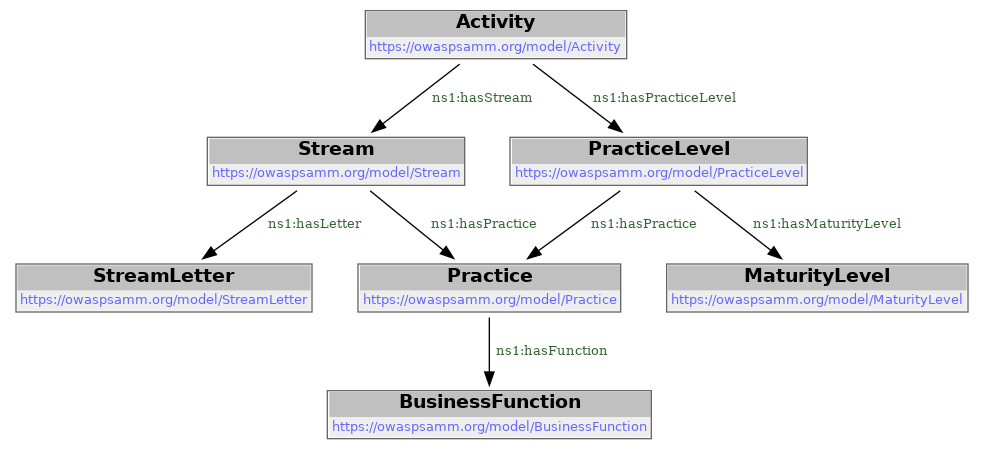